In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

#import keras
#from keras import layers
# from keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model

import glob, os

# Load Dataset

In [3]:
x_nose = np.load(r"C:\Users\DI Lee\Desktop\capstone_github\dognose_recognition_management_service\dognose_recognition\dataset\npy\noseprint_sobel_all.npy")#['data']
y_nose = np.load(r"C:\Users\DI Lee\Desktop\capstone_github\dognose_recognition_management_service\dognose_recognition\dataset\npy\noseprint_label_sobel_all.npy")

# Train Test Split

In [4]:
x_train, x_val, label_train, label_val = train_test_split(x_nose, y_nose, test_size=0.2)

print(x_nose.shape, y_nose.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(9640, 96, 96) (9640, 4)
(7712, 96, 96) (7712, 4)
(1928, 96, 96) (1928, 4)


# Preview Augmentation

In [5]:
data_size= 900

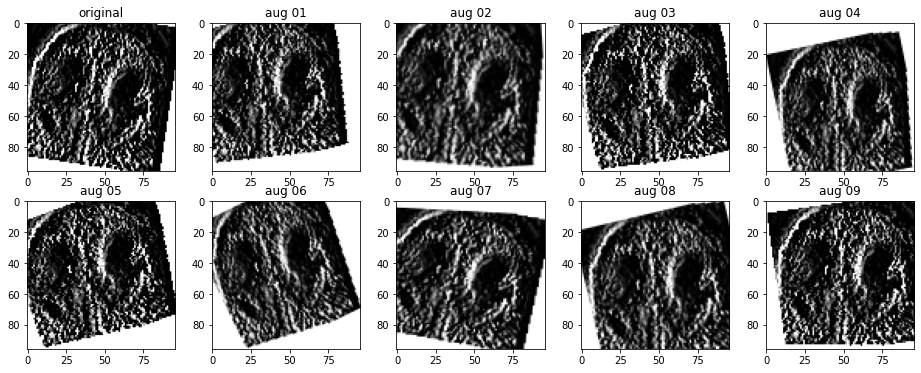

In [6]:
augs = [x_nose[data_size]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_nose[data_size].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [7]:
label_real_dict = {}

for i, y in enumerate(y_nose):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
# class DataGenerator(tf.keras.utils.all_utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [9]:
train_gen = DataGenerator(x_train, label_train, x_nose, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_nose, label_real_dict, shuffle=False)

In [10]:
len(train_gen)

241

# Create Model

In [11]:
x1 = layers.Input(shape=(96, 96, 1))
x2 = layers.Input(shape=(96, 96, 1))

# share weights both inputs
inputs = layers.Input(shape=(96, 96, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

feature_model.summary()
# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        9248  

# Train

In [12]:
history = model.fit(train_gen, epochs= 30, validation_data=val_gen)

Epoch 1/30
241/241 [==============================] - 8s 24ms/step - loss: 0.3925 - acc: 0.8432 - val_loss: 0.2651 - val_acc: 0.9406
Epoch 2/30
241/241 [==============================] - 6s 23ms/step - loss: 0.2771 - acc: 0.9087 - val_loss: 0.2273 - val_acc: 0.9302
Epoch 3/30
241/241 [==============================] - 6s 25ms/step - loss: 0.2414 - acc: 0.9205 - val_loss: 0.1816 - val_acc: 0.9448
Epoch 4/30
241/241 [==============================] - 6s 24ms/step - loss: 0.2519 - acc: 0.9170 - val_loss: 0.1814 - val_acc: 0.9427
Epoch 5/30
241/241 [==============================] - 6s 23ms/step - loss: 0.2264 - acc: 0.9230 - val_loss: 0.1605 - val_acc: 0.9557
Epoch 6/30
241/241 [==============================] - 6s 23ms/step - loss: 0.2221 - acc: 0.9262 - val_loss: 0.1520 - val_acc: 0.9578
Epoch 7/30
241/241 [==============================] - 6s 23ms/step - loss: 0.2160 - acc: 0.9274 - val_loss: 0.1935 - val_acc: 0.9401
Epoch 8/30
241/241 [==============================] - 5s 22ms/step - 

In [13]:
model.evaluate(val_gen)

60/60 [==============================] - 1s 10ms/step - loss: 0.1201 - acc: 0.9682


[0.12006974965333939, 0.9682291746139526]

### 훈련과정 시각화

In [14]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

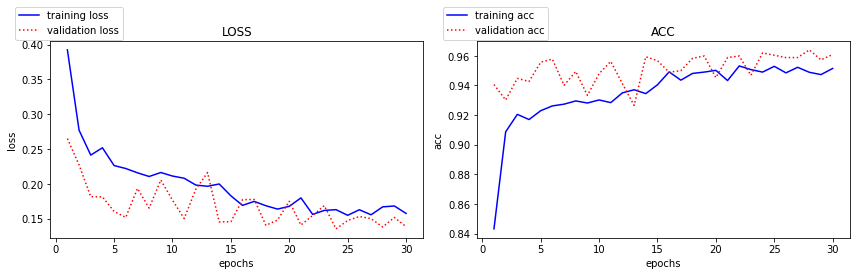

In [15]:
plot_history(history)

### Model save

In [16]:
model.save('./model/sobel.h5')
loaded_model = tf.keras.models.load_model("./model/sobel.h5")
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 12, 12, 32)   18816       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 12, 12, 32)   0           ['model[0][0]',            

In [17]:
loaded_model.evaluate(val_gen)

60/60 [==============================] - 1s 11ms/step - loss: 0.1422 - acc: 0.9599


[0.14222539961338043, 0.9598958492279053]

# Evaluation

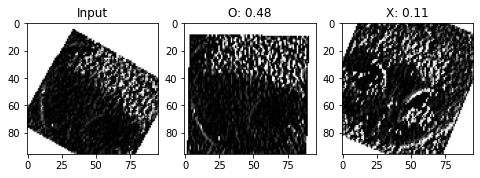

In [18]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 96, 96, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_nose[label_real_dict[match_key]].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
ry = y_nose[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_nose[unmatch_idx].reshape((1, 96, 96, 1)).astype(np.float32) / 255.
uy = y_nose[unmatch_idx]

pred_ux = model.predict([random_img, ux])

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
# plt.title('Input: %s' %random_label)
plt.title('Input')
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
# plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.title('O: %.02f' % (pred_rx))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
# plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.title('X: %.02f' % (pred_ux))
plt.imshow(ux.squeeze(), cmap='gray')

In [19]:
pred_rx = model.predict([random_img, rx])
pred_rx

array([[0.47531736]], dtype=float32)

# Test

In [20]:
def unsharpMasking(img): #unsharpMasking까지 전처리 
#     img = cv2.resize(img, (350, 350))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize=(3, 3), sigmaX=0)
    mask = gray - blurred
    #맨처음 alpha 1이였음 높아질수록 코주름이 더 많이 나옴 8까지 해봤는데 4가 가장 ㄱㅊ은듯요
    alpha = 2
    unsharp = gray + alpha * mask
    return unsharp

image

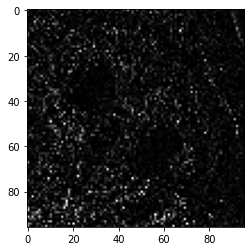

In [21]:
img_path = r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084.jpg"

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_path)
img = unsharpMasking(img)

img = cv2.Sobel(img, cv2.CV_8U, 1, 0, 3)
# img = cv2.Laplacian(img, cv2.CV_8U, ksize=3)
# img = cv2.Canny(img, 100, 255)

img = cv2.resize(img, (96, 96))
plt.imshow(img, cmap='gray')

np.save(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084.npy", img)

# print(img.shape)

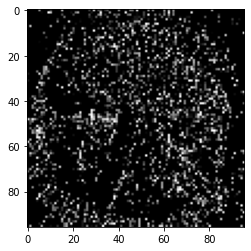

In [22]:
img_path = r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084_01.jpg"

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_path)
img = unsharpMasking(img)

img = cv2.Sobel(img, cv2.CV_8U, 1, 0, 3)
# img = cv2.Laplacian(img, cv2.CV_8U, ksize=3)
img = cv2.Canny(img, 100, 255)

img = cv2.resize(img, (96, 96))
plt.imshow(img, cmap='gray')

np.save(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084_01.npy", img)
# print(p_img.shape)

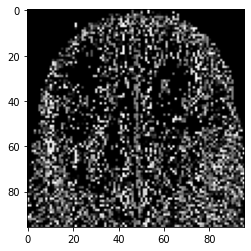

In [23]:
img_path = r"C:\Users\DI Lee\Desktop\capstone\dataset\test\ttttt.jpg"

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(img_path)
img = unsharpMasking(img)

img = cv2.Sobel(img, cv2.CV_8U, 1, 0, 3)
# img = cv2.Laplacian(img, cv2.CV_8U, ksize=3)
img = cv2.Canny(img, 100, 255)

img = cv2.resize(img, (96, 96))
plt.imshow(img, cmap='gray')

np.save(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\ttttt.npy", img)
# print(n_img.shape)

In [24]:
img = np.load(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084.npy")
p_img = np.load(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\KakaoTalk_20221130_225637084_01.npy")
n_img = np.load(r"C:\Users\DI Lee\Desktop\capstone\dataset\test\ttttt.npy")


In [25]:
img = img.reshape((1, 96, 96, 1)).astype(np.float32) / 255
p_img = p_img.reshape((1, 96, 96, 1)).astype(np.float32) / 255
n_img = n_img.reshape((1, 96, 96, 1)).astype(np.float32) / 255

In [26]:
pred_p = model.predict([img, p_img])
print(pred_p)

[[0.0929199]]


In [27]:
pred_n = model.predict([img, n_img])
print(pred_n)

[[0.08386915]]
